In [27]:
import os
import csv
import numpy as np
import pandas as pd
import multiprocessing
from time import perf_counter
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
    permutation_test_score, cross_validate,cross_val_predict
)
from sklearn.metrics import roc_auc_score,r2_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from concurrent.futures import ProcessPoolExecutor, as_completed
import statsmodels.api as sm
from collections import Counter
import json
import warnings
import re 
from scipy.stats import pearsonr,spearmanr
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import Ridge
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [28]:
import sklearn
from sklearn.preprocessing import OneHotEncoder as _OneHotEncoder

# Wrapper de compatibilité par composition
class OneHotEncoderCompat:
    def __init__(self, *args, **kwargs):
        if "sparse" in kwargs and "sparse_output" not in kwargs:
            kwargs["sparse_output"] = kwargs.pop("sparse")
        self._enc = _OneHotEncoder(*args, **kwargs)

    def fit(self, X, y=None):
        return self._enc.fit(X, y)

    def transform(self, X):
        return self._enc.transform(X)

    def fit_transform(self, X, y=None):
        return self._enc.fit_transform(X, y)

    def get_feature_names_out(self, *args, **kwargs):
        return self._enc.get_feature_names_out(*args, **kwargs)

    def __getattr__(self, name):
        return getattr(self._enc, name)

import neurocombat_sklearn
neurocombat_sklearn.neurocombat_sklearn.OneHotEncoder = OneHotEncoderCompat
from neurocombat_sklearn import CombatModel

import neurocombat_sklearn.neurocombat_sklearn as ncs

print("OneHotEncoder patché ? ->", ncs.OneHotEncoder)



OneHotEncoder patché ? -> <class '__main__.OneHotEncoderCompat'>


In [29]:
# CONFIG
labels_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/prematurity_labels_true_classes.csv"
base_path  = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/embeddings/ABCD_embeddings/"
output_csv  = "/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/ABCD_cog_results_final_all.csv"
thresholds  = ["28-32"]

In [30]:
labels_df = pd.read_csv(labels_path, low_memory=False)
labels_df['src_subject_id'] = labels_df['src_subject_id'].str.replace("_","")

In [31]:
def load_embeddings(region):
    
    for file in os.listdir(base_path):
            if file.startswith(region) and file.endswith(".csv"):
                embedding_file = file
                break
            
    if embedding_file is None:
        raise FileNotFoundError(f"No embedding file found for region: {region}")

    print(f"Using embedding file: {embedding_file}")

    emb_path = os.path.join(base_path, embedding_file)
    emb_df = pd.read_csv(emb_path)
    emb_df['ID_clean'] = (
        emb_df['ID'].astype(str)
        .str.replace(r"^sub-", "", regex=True)
        .str.replace("_", "", regex=False)
    )
    return emb_df
    

In [32]:
def define_sex_class_mapping(sex_series):


    unique_sex = sorted(sex_series.unique())

    #print("unique sites :", unique_sex)

    mapping = {1.0: 0, 2.0:1, 3.0 : 1}
    
    def encoder_fn(site):
        return mapping[site]
    
    return mapping, encoder_fn

def define_scan_age_mapping(scan_ages_series): 


    unique_scan_ages = sorted(scan_ages_series.unique())



    scaler = StandardScaler()
    scan_ages =np.array(scan_ages_series).reshape(-1 ,1)
    scaler.fit(scan_ages)
    #print("unique_scan_ages :",unique_scan_ages)

    def encoder_fn(scan_age):
        return scaler.transform(np.array([[scan_age]])).item()

    
    return scaler, encoder_fn

In [33]:
def set_confound_df(label_counfounds_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/all_labels_clean_abcd_new_classes.csv",income_df_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/income.csv"):
    
    counfounds_df = pd.read_csv(label_counfounds_path)
    counfounds_df = pd.get_dummies(counfounds_df,columns = ['site_id_l'],prefix='',prefix_sep='',drop_first=True)
    income_df = pd.read_csv(income_df_path)
    income_df['src_subject_id_clean'] = income_df['src_subject_id'].str.replace("_","")
    #keep only necessary columns
    income_df = income_df[['src_subject_id_clean','income_continuous','missing_income']]


    mapping, encode_site = define_sex_class_mapping(counfounds_df['demo_sex_v2'])
    counfounds_df['sex'] = counfounds_df['demo_sex_v2'].apply(encode_site)
    counfounds_df.drop(columns=['demo_sex_v2'],inplace=True)


    counfounds_df["interview_age"].fillna(115,inplace =True)

    scaler, encode_scan_age = define_scan_age_mapping(counfounds_df["interview_age"])

    counfounds_df['scan_age']= counfounds_df['interview_age'].apply(encode_scan_age)

    counfounds_df = counfounds_df.merge(income_df,left_on='src_subject_id_clean',how='left',right_on='src_subject_id_clean')


    # Filter to keep only necessary columns
    columns_to_keep = ['scan_age','sex','src_subject_id_clean','income_continuous','missing_income'] + [col for col in counfounds_df.columns if col.startswith('site')]
    counfounds_df = counfounds_df[columns_to_keep]

    #print("counfounds_df columns :",counfounds_df.columns) 

    return counfounds_df


set_confound_df()


/tmp/ipykernel_511057/679597559.py:3: DtypeWarning: Columns (307,338,352,385,397,405,436,443) have mixed types. Specify dtype option on import or set low_memory=False.
  counfounds_df = pd.read_csv(label_counfounds_path)
/tmp/ipykernel_511057/679597559.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  counfounds_df["interview_age"].fillna(115,inplace =True)


,scan_age,sex,src_subject_id_clean,income_continuous,missing_income,site02,site03,site04,site05,site06,...,site13,site14,site15,site16,site17,site18,site19,site20,site21,site22
0,1.608618,1,NDARINV003RTV85,8.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,0.939494,0,NDARINV007W6H7B,10.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,-0.934053,0,NDARINV00BD7VDC,10.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.671845,0,NDARINV00HEV6HB,8.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-1.201702,0,NDARINV00J52GPG,6.0,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980,-1.201702,1,NDARINVZZLZCKAY,9.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
9981,-0.800228,1,NDARINVZZPKBDAC,10.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9982,0.270370,1,NDARINVZZZ2ALR6,10.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9983,-1.469352,1,NDARINVZZZNB0XC,3.0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [34]:
def _is_categorical(series, max_unique_for_cat=10):
    """if dtype is object or has few unique values, treat as categorical."""
    if series.dtype == object:
        return True
    if pd.api.types.is_integer_dtype(series) and series.nunique() <= max_unique_for_cat:
        return True
    return False

def _bin_continuous_for_strat(series, n_bins):
    """Returns a series of categories in quantiles; if qcut fails, falls back to cut."""
    try:
        b = pd.qcut(series, q=n_bins, duplicates='drop')
    except Exception:
        b = pd.cut(series, bins=n_bins, duplicates='drop')
    # transformer en string simple
    b = b.astype(str)
    # remplacer 'nan' par 'missing' si des NA
    b = b.fillna('missing')
    return b

In [35]:
def _is_categorical(s, max_unique_for_cat=10):
    return (s.dtype == 'object') or (pd.api.types.is_bool_dtype(s)) or (s.nunique(dropna=True) <= max_unique_for_cat)

def _bin_continuous_for_strat(x, n_bins):
    q = np.linspace(0, 1, n_bins + 1)
    edges = np.unique(np.nanquantile(x, q))
    if len(edges) <= 2:
        edges = np.unique(np.nanquantile(x, [0, 0.5, 1.0]))
    labels = [f"b{i}" for i in range(len(edges)-1)]
    return pd.cut(x, bins=edges, include_lowest=True, labels=labels).astype(str)

def _derive_site_from_onehot(df, pattern=r'^site\d{2}$', missing_label='site_missing'):
    site_cols = [c for c in df.columns if re.match(pattern, c)]
    if not site_cols:
        return None, []
    arg = df[site_cols].astype(float).values
    ix = np.argmax(arg, axis=1)
    site_series = pd.Series(
        [site_cols[i] if (arg[row, i] == 1.0) else missing_label
         for row, i in enumerate(ix)],
        index=df.index, name='site_cat'
    )
    mask_all_zero = (arg.sum(axis=1) == 0)
    site_series.loc[mask_all_zero] = missing_label
    return site_series, site_cols

def _collapse_rare_sites(site_array, min_size):
    counts = Counter(site_array)
    return np.array([s if counts[s] >= min_size else "site_other" for s in site_array])

def prepare_cv_data(
    embeddings_df,
    labels_df,
    confounds_df,
    id_emb_col='ID_clean',
    id_label_col='src_subject_id',
    id_conf_col='src_subject_id_clean',
    confounds_for_strat=[],
    confounds_for_resid=None,
    threshold="28-32",
    dim_regex=r'^dim',
    n_splits=5,
    init_n_bins=5,
    max_unique_for_cat=10,
    site_onehot_regex=r'^site\d{2}$',
    min_site_size=50  
):
    emb = embeddings_df.copy()
    lab = labels_df.copy()
    cf  = confounds_df.copy()

    emb[id_emb_col]   = emb[id_emb_col].astype(str)
    lab[id_label_col] = lab[id_label_col].astype(str)
    cf[id_conf_col]   = cf[id_conf_col].astype(str)

    merged = emb.merge(lab, left_on=id_emb_col, right_on=id_label_col, how='inner')
    df = merged.merge(cf, left_on=id_emb_col, right_on=id_conf_col, how='inner', suffixes=('','_cf'))

    # cible binaire
    df = df[df['prem_class'].isin([">=37"])].copy()
    df['y'] = (df['prem_class'].isin([">=37"])).astype(int)

    # reconstruire l’étiquette de site à partir du one-hot
    site_cat, site_cols = _derive_site_from_onehot(df, pattern=site_onehot_regex)
    if site_cat is None:
        raise ValueError(f"Aucune colonne de site détectée avec le regex {site_onehot_regex}.")
    df['site_cat'] = site_cat.astype(str)

    # collapse des sites trop petits
    if min_site_size is None:
        min_site_size = n_splits  # par défaut : au moins n_splits sujets
    df['site_cat'] = _collapse_rare_sites(df['site_cat'].values, min_site_size)

    # X / y / ids
    X_all_df = df.filter(regex=dim_regex)
    X_all = X_all_df.to_numpy(dtype=float)
    y_all = df['y'].to_numpy(dtype=int)
    ids_all = df[id_label_col].astype(str).to_numpy()

    # confounds pour résidualisation
    if confounds_for_resid is None:
        confounds_for_resid = confounds_df.columns.tolist()
        if id_conf_col in confounds_for_resid:
            confounds_for_resid.remove(id_conf_col)
    confounds_for_resid = [c for c in confounds_for_resid if c not in site_cols and c != 'site_cat']
    confounds_resid_df = df[confounds_for_resid].copy()

    # stratification : site uniquement (y peut être ignoré si tu n’as que des prémas)
    confounds_for_strat = list(confounds_for_strat) if confounds_for_strat is not None else []
    if 'site_cat' not in confounds_for_strat:
        confounds_for_strat.append('site_cat')

    stratify_labels = df['site_cat'].astype(str).to_numpy()

    # count occurrences
    counts = Counter(stratify_labels)
    print("Occurrences par strata pour stratification :", counts)

    return {
        'df_complete': df,
        'X_all_df': X_all_df,
        'X_all': X_all,
        'y_all': y_all,
        'ids_all': ids_all,
        'stratify_labels': stratify_labels,
        'confounds_resid_df': confounds_resid_df,
        'site_array': df['site_cat'].astype(str).to_numpy(),
        'site_onehot_cols': site_cols,
    }


In [14]:
def regress_cognition_with_resid(
    folds_residualized,
    cognition_col,
    df_cognition_path="/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/df_with_cognition_and_ages.csv",
    param_grid={'regressor__alpha':[0.01,0.1,1,10]},
    n_jobs=-1,
    num_bootstrap=1000,
    n_permutations=11200,
    random_state=42,
):
    # Récupérer l’entrée "full" (résidualisation globale pour le tuning)
    full = next(e for e in folds_residualized[::-1] if 'X_all_resid' in e)
    df_cog = pd.read_csv(df_cognition_path)[['src_subject_id', cognition_col]]
    df_all = full['df_resid'].merge(df_cog, on='src_subject_id', how='left')
    X_all_resid = df_all.filter(regex=r'^dim').values
    y_all = df_all[cognition_col].values.astype(float)

    keep_all = ~np.isnan(y_all)
    X_all_resid, y_all = X_all_resid[keep_all], y_all[keep_all]

    #Global tunning sur X_all_resid 
    inner = KFold(n_splits=min(5, len(y_all)), shuffle=True, random_state=random_state) if len(y_all) >= 5 else 3
    pipe = Pipeline([('scaler', StandardScaler()), ('regressor', Ridge())])
    grid = GridSearchCV(pipe, param_grid, cv=inner, scoring='r2', refit=True, n_jobs=n_jobs)
    grid.fit(X_all_resid, y_all)
    best_alpha = float(grid.best_params_.get('regressor__alpha', 1.0))

    # Évaluation outer sur folds PROPREMENT résidualisés (zéro fuite de résidualisation) --------
    outer_ytrue, outer_pred, r2_per_fold = [], [], []

    # petit dict id->y pour mapper les y par fold
    id2y = dict(zip(df_all['src_subject_id'].astype(str), df_all[cognition_col].values))

    for f in folds_residualized:
        if 'X_train_resid' not in f:
            continue
        Xtr, Xte = f['X_train_resid'], f['X_test_resid']
        ytr = np.array([id2y[i] for i in f['train_ids']], dtype=float)
        yte = np.array([id2y[i] for i in f['test_ids']], dtype=float)

        # drop NaN cognition
        keep_tr, keep_te = ~np.isnan(ytr), ~np.isnan(yte)
        Xtr, ytr = Xtr[keep_tr], ytr[keep_tr]
        Xte, yte = Xte[keep_te], yte[keep_te]
        if len(ytr) < 2 or len(yte) < 1:
            continue  # garde-fou

        model = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Ridge(alpha=best_alpha))
        ])
        model.fit(Xtr, ytr)
        yhat = model.predict(Xte)

        r2_per_fold.append(r2_score(yte, yhat))
        outer_ytrue.append(yte)
        outer_pred.append(yhat)

    outer_ytrue = np.concatenate(outer_ytrue) if len(outer_ytrue) else np.array([])
    outer_pred  = np.concatenate(outer_pred)  if len(outer_pred ) else np.array([])

    # Métriques + bootstrap + permutations sur OOF
    def _safe_corr(fun, a, b):
        try: return float(fun(a, b)[0])
        except Exception: return np.nan

    r_obs = _safe_corr(pearsonr, outer_ytrue, outer_pred)
    s_obs = _safe_corr(spearmanr, outer_ytrue, outer_pred)

    r2_mean = float(np.mean(r2_per_fold)) if r2_per_fold else np.nan
    r2_std  = float(np.std(r2_per_fold))  if r2_per_fold else np.nan

    rng = np.random.default_rng(42)
    n = len(outer_ytrue)
    pearson_bs, spearman_bs = [], []
    for _ in range(num_bootstrap):
        idx = rng.integers(0, n, n)
        pearson_bs.append(_safe_corr(pearsonr, outer_ytrue[idx], outer_pred[idx]))
        spearman_bs.append(_safe_corr(spearmanr, outer_ytrue[idx], outer_pred[idx]))
    pearson_ci = np.nanpercentile(pearson_bs, [2.5, 97.5]).tolist()
    spearman_ci = np.nanpercentile(spearman_bs, [2.5, 97.5]).tolist()
    z = np.arctanh(np.clip(pearson_bs, -0.999999, 0.999999))
    lo, hi = np.nanpercentile(z, [2.5, 97.5])
    pearson_ci_fisher = [float(np.tanh(lo)), float(np.tanh(hi))]

    pearson_perm, spearman_perm = [], []
    for _ in range(n_permutations):
        y_perm = rng.permutation(outer_ytrue)
        pearson_perm.append(_safe_corr(pearsonr, y_perm, outer_pred))
        spearman_perm.append(_safe_corr(spearmanr, y_perm, outer_pred))
    p_pearson = (np.sum(np.array(pearson_perm) >= r_obs) + 1) / (n_permutations + 1)
    p_spearman = (np.sum(np.array(spearman_perm) >= s_obs) + 1) / (n_permutations + 1)

    # Refit final pour coefficients (sur tout X_all_resid, avec best_alpha)
    final_pipe = Pipeline([('scaler', StandardScaler()), ('regressor', Ridge(alpha=best_alpha))])
    final_pipe.fit(X_all_resid, y_all)
    reg, sc = final_pipe.named_steps['regressor'], final_pipe.named_steps['scaler']
    w_x = reg.coef_.ravel() / sc.scale_
    b_x = float(reg.intercept_) - np.dot(w_x, sc.mean_)

    results = {
        'best_alpha_global': best_alpha,
        'r2_per_fold': list(map(float, r2_per_fold)),
        'r2_mean': r2_mean,
        'r2_std': r2_std,
        'r_oof': r_obs,
        'r_oof_ci95': pearson_ci,
        'r_oof_ci95_fisher': pearson_ci_fisher,
        's_oof': s_obs,
        's_oof_ci95': spearman_ci,
        'p_pearson': float(p_pearson),
        'p_spearman': float(p_spearman),
        'n_subjects_oof': int(len(outer_ytrue)),
        'n_subjects_full_refit': int(len(y_all)),
    }
    direction = {
        'final_estimator': final_pipe,
        'final_coef_original': w_x,
        'final_intercept_original': b_x,
    }
    return results, direction


In [36]:
def residualize_in_folds_from_prep_combat_final(
    prep,
    confounds_list=None,
    id_label_col='src_subject_id',
    id_emb_col='ID_clean',
    dim_regex=r'^dim',
    n_splits=5,
    random_state=42,
    use_statsmodels=True,
    use_combat=True,
):
    merged_df = prep['df_complete'].copy()
    X_all = prep['X_all']; y_all = prep['y_all']; ids_all = prep['ids_all']
    stratify_labels = prep['stratify_labels']
    confounds_df = prep['confounds_resid_df']

    # --------------- confounds list (déjà propres depuis prepare_cv_data) ---------------
    if confounds_list is None:
        confounds_list = list(confounds_df.columns)  # aligné aux sujets filtrés
        # retire les id-like si présents
        confounds_list = [c for c in confounds_list if not re.search(r'(src|id)', c, flags=re.I)]

    # colonnes site à exclure de l'OLS (toutes les one-hot + site_cat)
    site_onehot_cols = [c for c in merged_df.columns if re.match(r'^site\d{2}$', c)]
    site_like_cols = set(site_onehot_cols + (['site_cat'] if 'site_cat' in merged_df.columns else []))
    confounds_list = [c for c in confounds_list if c not in site_like_cols]

    # split confounds en continu / discret (si tu en as besoin pour ComBat)
    preferred_cont = ['scan_age', 'income_continuous']
    preferred_disc = ['missing_income', 'sex']
    confounds_continuous = [c for c in preferred_cont if c in merged_df.columns and c in confounds_list]
    confounds_discrete  = [c for c in preferred_disc if c in merged_df.columns and c in confounds_list]
    remaining = [c for c in confounds_list if c not in (confounds_continuous + confounds_discrete)]
    confounds_continuous += remaining  # par défaut en continu

    # --------------- site/batch pour ComBat : utilise prep['site_array'] ---------------
    if use_combat:
        if 'site_array' in prep:
            site_series = pd.Series(prep['site_array'], index=merged_df.index).astype(str)
        else:
            # fallback: reconstruire depuis le one-hot si jamais
            if not site_onehot_cols:
                raise RuntimeError("Aucune info de site trouvée (ni site_array, ni siteXX).")
            ix = np.argmax(merged_df[site_onehot_cols].astype(float).values, axis=1)
            site_series = pd.Series([site_onehot_cols[i] for i in ix], index=merged_df.index, dtype=str)

        le = LabelEncoder()
        batch_all = le.fit_transform(site_series.values)  # ex: 'site02' -> 0..K-1
    else:
        batch_all = None

    # --------------- dims ----------------
    dim_cols = merged_df.filter(regex=dim_regex).columns.tolist()

    # --------------- K-fold (strat sur y||site_cat||confounds binned) ----------------
    outer = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    folds_residualized = []
    id_to_y = dict(zip(ids_all.astype(str), y_all.astype(int)))

    for fold_i, (train_idx, test_idx) in enumerate(outer.split(X_all, stratify_labels)):
        train_ids = ids_all[train_idx].astype(str); test_ids = ids_all[test_idx].astype(str)

        merged_df[id_emb_col] = merged_df[id_emb_col].astype(str)
        train_mask = merged_df[id_emb_col].isin(train_ids)
        test_mask  = merged_df[id_emb_col].isin(test_ids)

        X_train_emb_df = merged_df.loc[train_mask, dim_cols].astype(float)
        X_test_emb_df  = merged_df.loc[test_mask,  dim_cols].astype(float)

        # ---------- ComBat (fit sur train, transform sur test) ----------
        if use_combat:
            from neurocombat_sklearn import CombatModel
            # covariables continues (remplissage par stats train)
            if len(confounds_continuous) > 0:
                cont_train_df = merged_df.loc[train_mask, confounds_continuous].astype(float).copy()
                cont_test_df  = merged_df.loc[test_mask,  confounds_continuous].astype(float).copy()
                cont_train_df = cont_train_df.fillna(cont_train_df.median())
                cont_test_df  = cont_test_df.fillna(cont_train_df.median())
                continuous_train_arr = cont_train_df.values
                continuous_test_arr  = cont_test_df.values
            else:
                continuous_train_arr = None; continuous_test_arr = None

            # covariables discrètes
            if len(confounds_discrete) > 0:
                disc_train_df = merged_df.loc[train_mask, confounds_discrete].copy()
                disc_test_df  = merged_df.loc[test_mask,  confounds_discrete].copy()
                for c in disc_train_df.columns:
                    mv = disc_train_df[c].mode().iloc[0]
                    disc_train_df[c] = disc_train_df[c].fillna(mv)
                    disc_test_df[c]  = disc_test_df[c].fillna(mv)
            else:
                disc_train_df = pd.DataFrame(index=X_train_emb_df.index)
                disc_test_df  = pd.DataFrame(index=X_test_emb_df.index)

            # préserver y (en discrète) pour éviter de l’écraser
            # y_train_list = [id_to_y[i] for i in merged_df.loc[train_mask, id_emb_col]]
            # y_test_list  = [id_to_y[i] for i in merged_df.loc[test_mask,  id_emb_col]]
            # disc_train_df = pd.concat([
            #     disc_train_df.reset_index(drop=True),
            #     pd.Series(y_train_list, name='__y_preserve')
            # ], axis=1).set_index(X_train_emb_df.index)
            # disc_test_df = pd.concat([
            #     disc_test_df.reset_index(drop=True),
            #     pd.Series(y_test_list, name='__y_preserve')
            # ], axis=1).set_index(X_test_emb_df.index)

            discrete_train_arr = disc_train_df.values if disc_train_df.shape[1] > 0 else None
            discrete_test_arr  = disc_test_df.values  if disc_test_df.shape[1] > 0 else None

            batch_train = batch_all[train_mask.values].reshape(-1, 1)
            batch_test  = batch_all[test_mask.values].reshape(-1, 1)

            # sécurité : tout site présent en test doit exister en train
            miss = np.setdiff1d(np.unique(batch_test), np.unique(batch_train))
            if miss.size:
                raise RuntimeError(f"Fold {fold_i}: site(s) uniquement en test → {miss}. "
                                   f"Assure-toi que 'site_cat' est inclus dans stratify_labels.")

            combat = CombatModel()
            X_train_h = combat.fit_transform(X_train_emb_df.values, batch_train, discrete_train_arr, continuous_train_arr)
            X_test_h  = combat.transform(X_test_emb_df.values,  batch_test,  discrete_test_arr,  continuous_test_arr)

            X_train_h_df = pd.DataFrame(X_train_h, index=X_train_emb_df.index, columns=dim_cols)
            X_test_h_df  = pd.DataFrame(X_test_h,  index=X_test_emb_df.index,  columns=dim_cols)
        else:
            X_train_h_df = X_train_emb_df.copy()
            X_test_h_df  = X_test_emb_df.copy()

        # ---------- OLS residualization (sur embeddings harmonisés) ----------
        conf_train_df = merged_df.loc[train_mask, confounds_list].copy() if len(confounds_list)>0 else pd.DataFrame(index=X_train_h_df.index)
        conf_test_df  = merged_df.loc[test_mask,  confounds_list].copy() if len(confounds_list)>0 else pd.DataFrame(index=X_test_h_df.index)

        if conf_train_df.shape[1] > 0:
            for c in conf_train_df.columns:
                if pd.api.types.is_numeric_dtype(conf_train_df[c]):
                    med = conf_train_df[c].median()
                    conf_train_df[c] = conf_train_df[c].fillna(med)
                    conf_test_df[c]  = conf_test_df[c].fillna(med)
                else:
                    mv = conf_train_df[c].mode().iloc[0]
                    conf_train_df[c] = conf_train_df[c].fillna(mv)
                    conf_test_df[c]  = conf_test_df[c].fillna(mv)
        else:
            conf_train_df = pd.DataFrame(index=X_train_h_df.index)
            conf_test_df  = pd.DataFrame(index=X_test_h_df.index)

        if use_statsmodels:
            import statsmodels.api as sm
            X_conf_train = sm.add_constant(conf_train_df.astype(float), has_constant='add')
            X_conf_test  = sm.add_constant(conf_test_df.astype(float),  has_constant='add')
            resid_train_df = pd.DataFrame(index=X_train_h_df.index, columns=dim_cols, dtype=float)
            resid_test_df  = pd.DataFrame(index=X_test_h_df.index,  columns=dim_cols, dtype=float)
            for col in dim_cols:
                y_tr_col = X_train_h_df[col].astype(float)
                if X_conf_train.shape[1] == 0:
                    resid_train_df[col] = y_tr_col.values
                    resid_test_df[col]  = X_test_h_df[col].astype(float).values
                else:
                    ols = sm.OLS(y_tr_col, X_conf_train).fit()
                    resid_train_df[col] = y_tr_col - ols.predict(X_conf_train)
                    resid_test_df[col]  = X_test_h_df[col].astype(float) - ols.predict(X_conf_test)
        else:
            from sklearn.linear_model import LinearRegression
            if conf_train_df.shape[1] == 0:
                resid_train_df = X_train_h_df.copy()
                resid_test_df  = X_test_h_df.copy()
            else:
                lr = LinearRegression()
                lr.fit(conf_train_df.values, X_train_h_df.values)
                resid_train_df = pd.DataFrame(X_train_h_df.values - lr.predict(conf_train_df.values),
                                              index=X_train_h_df.index, columns=dim_cols)
                resid_test_df  = pd.DataFrame(X_test_h_df.values  - lr.predict(conf_test_df.values),
                                              index=X_test_h_df.index,  columns=dim_cols)

        # y aligné
        train_ids_present = merged_df.loc[train_mask, id_emb_col].astype(str).tolist()
        test_ids_present  = merged_df.loc[test_mask,  id_emb_col].astype(str).tolist()
        y_train = np.array([id_to_y[i] for i in train_ids_present], dtype=int)
        y_test  = np.array([id_to_y[i] for i in test_ids_present],  dtype=int)

        folds_residualized.append({
            'X_train_resid': resid_train_df.values,
            'X_test_resid' : resid_test_df.values,
            'y_train': y_train, 'y_test': y_test,
            'train_ids': train_ids_present, 'test_ids': test_ids_present
        })

    # ---------- Full-data (pour refit/visu) ----------
    merged_df_h = merged_df.copy()
    if use_combat:
        # mêmes covariables que plus haut (fill par stats globales)
        if len(confounds_continuous) > 0:
            full_cont_df = merged_df[confounds_continuous].astype(float).copy()
            full_cont_df = full_cont_df.fillna(full_cont_df.median())
            continuous_all_arr = full_cont_df.values
        else:
            continuous_all_arr = None

        if len(confounds_discrete) > 0:
            full_disc_df = merged_df[confounds_discrete].copy()
            for c in full_disc_df.columns:
                mv = full_disc_df[c].mode().iloc[0]
                full_disc_df[c] = full_disc_df[c].fillna(mv)
        else:
            full_disc_df = pd.DataFrame(index=merged_df.index)

        # full_disc_df = pd.concat([full_disc_df.reset_index(drop=True),
        #                           pd.Series(y_all.astype(int), name='__y_preserve')], axis=1).set_index(merged_df.index)
        discrete_all_arr = full_disc_df.values if full_disc_df.shape[1] > 0 else None

        batches_full = batch_all.reshape(-1, 1)
        from neurocombat_sklearn import CombatModel
        combat_full = CombatModel()
        X_all_h = combat_full.fit_transform(merged_df[dim_cols].values, batches_full, discrete_all_arr, continuous_all_arr)
        merged_df_h[dim_cols] = X_all_h

    # OLS full
    confounds_for_ols_full = list(confounds_list)  # déjà sans sites
    if len(confounds_for_ols_full) == 0:
        merged_df_resid = merged_df_h.copy()
    else:
        from sklearn.linear_model import LinearRegression
        full_conf_df = merged_df.loc[:, confounds_for_ols_full].copy()
        for c in full_conf_df.columns:
            if pd.api.types.is_numeric_dtype(full_conf_df[c]):
                full_conf_df[c] = full_conf_df[c].fillna(full_conf_df[c].median())
            else:
                full_conf_df[c] = full_conf_df[c].fillna(full_conf_df[c].mode().iloc[0])
        lr_full = LinearRegression().fit(full_conf_df.values, merged_df_h[dim_cols].values)
        X_all_resid = merged_df_h[dim_cols].values - lr_full.predict(full_conf_df.values)
        merged_df_resid = merged_df_h.copy(); merged_df_resid[dim_cols] = X_all_resid

    folds_residualized.append({
        'X_all_resid': merged_df_resid.filter(regex=dim_regex).values,
        'y_all': y_all, 'ids_all': ids_all, 'df_resid': merged_df_resid
    })
    return folds_residualized


In [43]:
# test on a single region and threshold

embeddings_df = load_embeddings("STi-SOTlat_right")
labels_df = labels_df
confounds_df = set_confound_df()
preps = prepare_cv_data(embeddings_df,labels_df,confounds_df,min_site_size=25)
folds_resids = residualize_in_folds_from_prep_combat_final(preps)
results = regress_cognition_with_resid(folds_resids,cognition_col="nihtbx_picvocab_agecorrected", n_jobs=-1 )

print(results)



Using embedding file: STi-SOTlat_right_name06-17-38--74_embeddings.csv


/tmp/ipykernel_309964/679597559.py:3: DtypeWarning: Columns (307,338,352,385,397,405,436,443) have mixed types. Specify dtype option on import or set low_memory=False.
  counfounds_df = pd.read_csv(label_counfounds_path)
/tmp/ipykernel_309964/679597559.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  counfounds_df["interview_age"].fillna(115,inplace =True)


Occurrences par strata pour stratification : Counter({'site16': 886, 'site04': 627, 'site20': 608, 'site13': 600, 'site10': 593, 'site12': 527, 'site14': 520, 'site21': 520, 'site03': 516, 'site17': 495, 'site06': 492, 'site02': 474, 'site19': 458, 'site11': 394, 'site09': 384, 'site15': 367, 'site_missing': 341, 'site05': 329, 'site07': 295, 'site18': 290, 'site08': 240, 'site22': 29})
({'best_alpha_global': 10.0, 'r2_per_fold': [0.007328026103717966, 0.016025337214139568, 0.011125570399584839, 0.003337950453866978, 0.002810524189027608], 'r2_mean': 0.008125481672067392, 'r2_std': 0.00496413967478437, 'r_oof': 0.09403744161901989, 'r_oof_ci95': [0.07551524745225557, 0.11339321227145077], 'r_oof_ci95_fisher': [0.07551524764831653, 0.11339321230943668], 's_oof': 0.09825570808964083, 's_oof_ci95': [0.0779842157046003, 0.11797950627089418], 'p_pearson': 0.000999000999000999, 'p_spearman': 0.000999000999000999, 'n_subjects_oof': 9852, 'n_subjects_full_refit': 9852}, {'final_estimator': Pip

Fold 0: train=1071, test=268
Fold 1: train=1071, test=268
Fold 2: train=1071, test=268
Fold 3: train=1071, test=268
Fold 4: train=1072, test=267


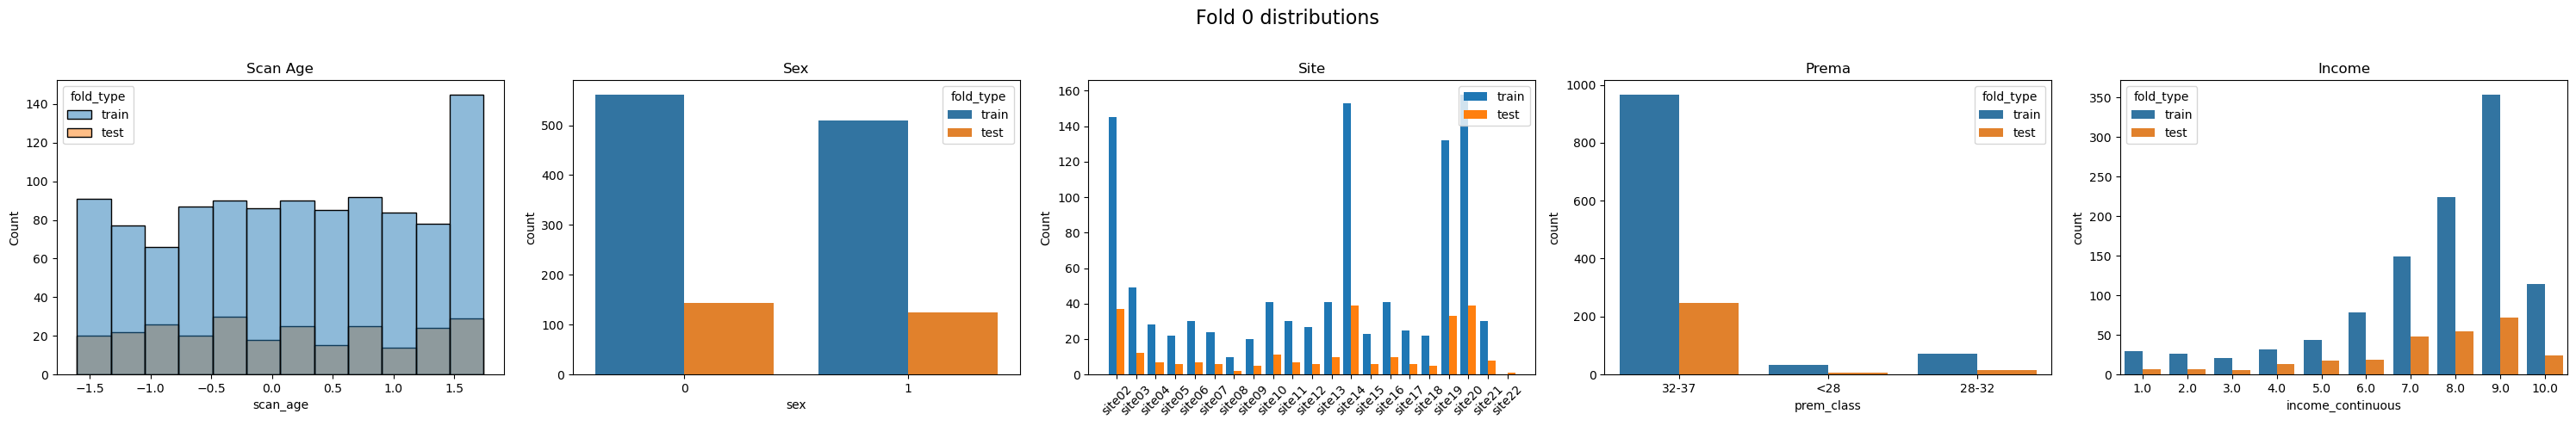

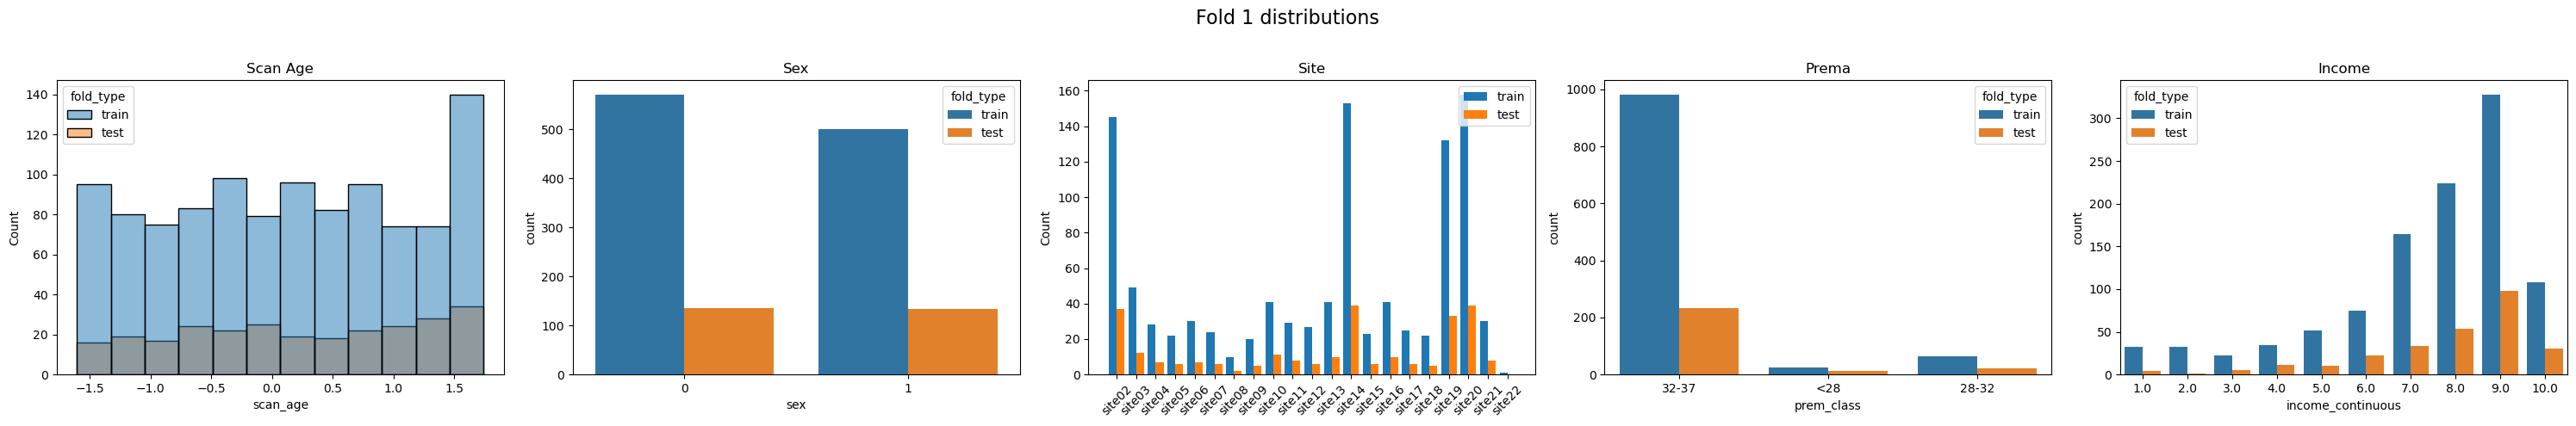

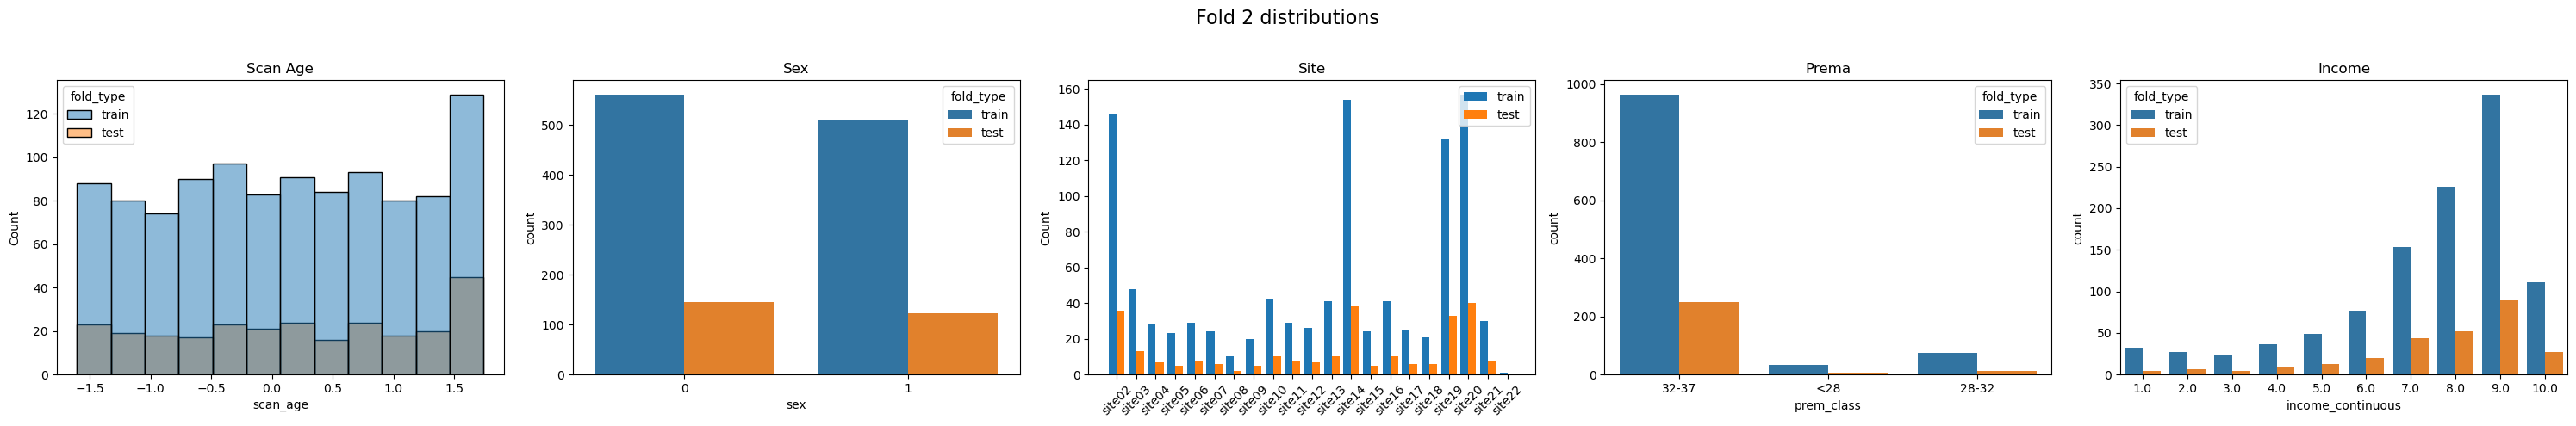

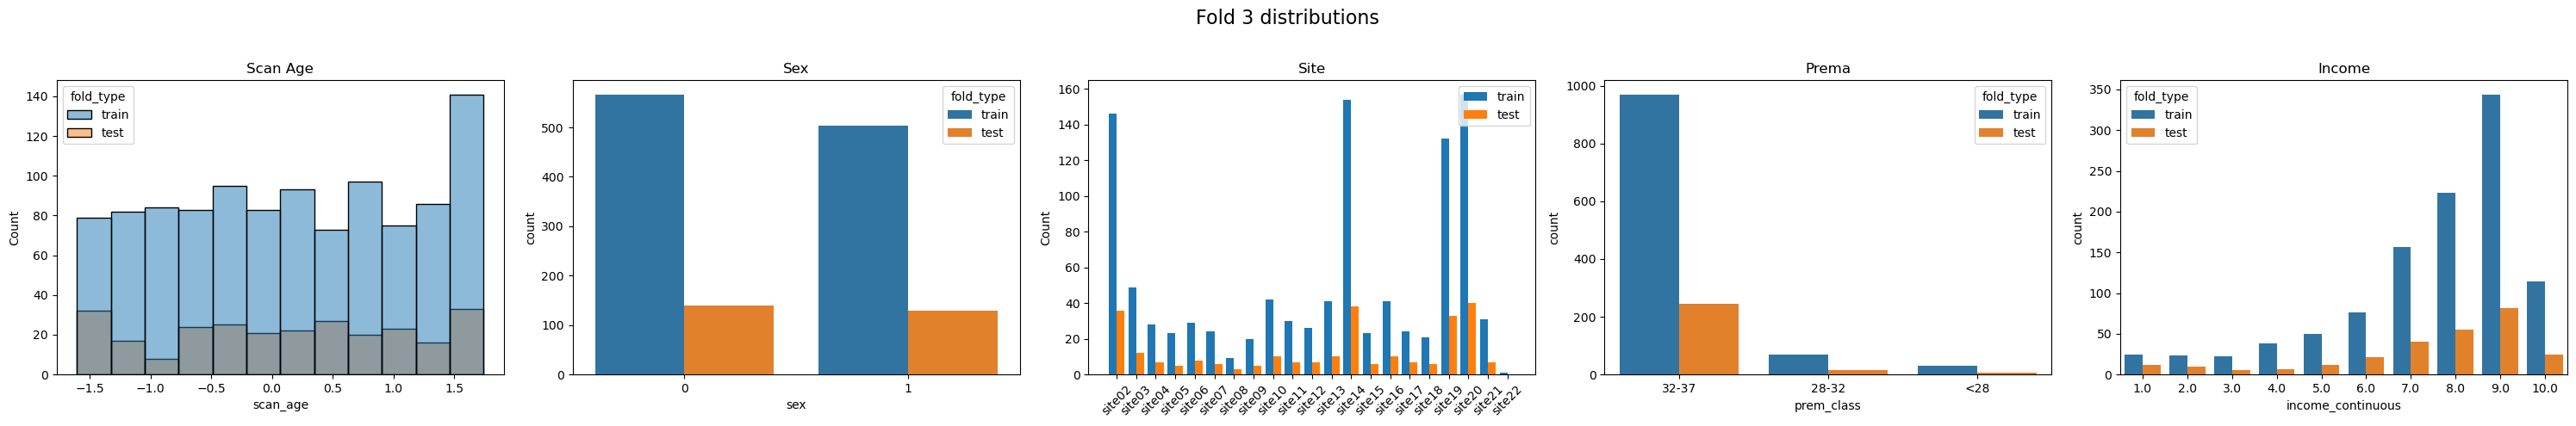

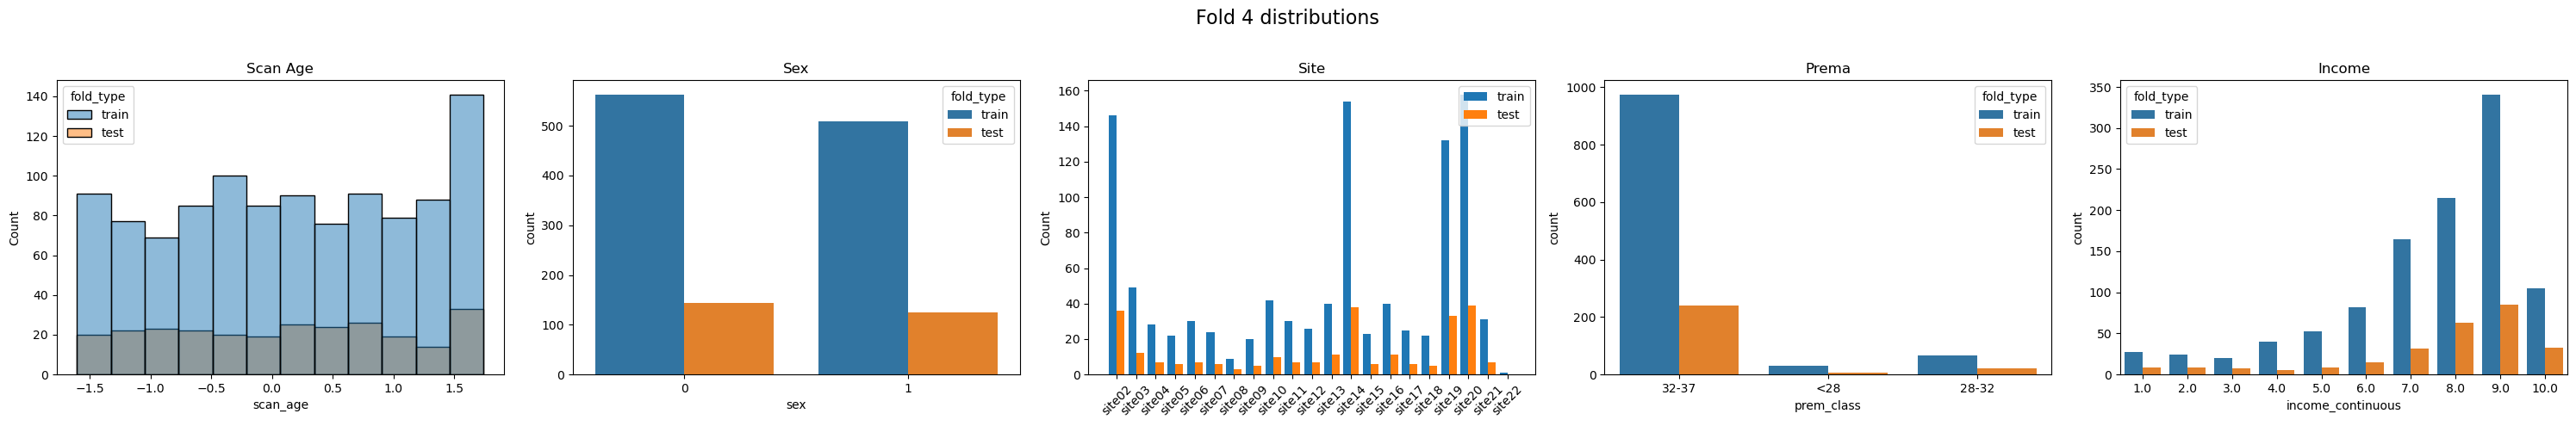

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_fold_distributions(folds_residualized, df_complete, id_label_col='subject_id'):
    """
    Plot distributions of scan_age, sex, site, and prema for each fold, 
    comparing train vs test sets.

    folds_residualized : list of dicts from residualize_in_folds_from_prep()
    df_complete : original dataframe containing scan_age, sex, site, prema, and IDs
    id_label_col : column name in df_complete that contains IDs
    
    """

    for i, fold in enumerate(folds_resids):
        if 'y_train' not in fold:
            continue
        print(f"Fold {i}: train={len(fold['train_ids'])}, test={len(fold['test_ids'])}")

    n_folds = len([f for f in folds_residualized if 'y_train' in f])

    for i, fold in enumerate(folds_residualized):
        if 'y_train' not in fold:
            continue

        train_ids = [str(x) for x in fold['train_ids']]
        test_ids  = [str(x) for x in fold['test_ids']]

        # Build a dataframe with fold_type
        df_train = df_complete[df_complete[id_label_col].astype(str).isin(train_ids)].copy()
        df_train['fold_type'] = 'train'

        df_test = df_complete[df_complete[id_label_col].astype(str).isin(test_ids)].copy()
        df_test['fold_type'] = 'test'

        df_fold = pd.concat([df_train, df_test])

        fig, axes = plt.subplots(1, 5, figsize=(30, 5))
        fig.suptitle(f"Fold {i} distributions", fontsize=16)

        # Scan age
        sns.histplot(data=df_fold, x='scan_age', hue='fold_type', kde=False, ax=axes[0])
        axes[0].set_title("Scan Age")

        # Sex
        sns.countplot(data=df_fold, x='sex', hue='fold_type', ax=axes[1])
        axes[1].set_title("Sex")

        # Site
        site_cols = [f'site{str(j).zfill(2)}' for j in range(2,23)]
        site_counts_train = df_fold[df_fold['fold_type']=='train'][site_cols].sum()
        site_counts_test  = df_fold[df_fold['fold_type']=='test'][site_cols].sum()
        x = np.arange(len(site_cols))
        axes[2].bar(x - 0.2, site_counts_train.values, width=0.4, label='train')
        axes[2].bar(x + 0.2, site_counts_test.values, width=0.4, label='test')
        axes[2].set_xticks(x)
        axes[2].set_xticklabels(site_cols, rotation=45)
        axes[2].set_ylabel("Count")
        axes[2].set_title("Site")
        axes[2].legend()

        # Prema
        sns.countplot(data=df_fold, x='prem_class', hue='fold_type', ax=axes[3])
        axes[3].set_title("Prema")

        # Income
        sns.countplot(data=df_fold, x='income_continuous', hue='fold_type', ax=axes[4])
        axes[4].set_title("Income")

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()



plot_fold_distributions(folds_resids, preps['df_complete'], id_label_col='src_subject_id')


In [37]:
def get_region_list(json_file_path="/neurospin/dico/data/deep_folding/current/sulci_regions_champollion_V1.json"):
   

    with open(json_file_path, 'r') as f:
        data = json.load(f)["brain"]


    def extract_keys(d, sep='_'):
        keys = []
        for k, v in d.items():
            new_key = k
            keys.append(new_key)

        return keys
    
    # Remove all the "." in the keys
    region_list = extract_keys(data)
    region_list = [region.replace('.','') for region in region_list]

    return region_list

region_list = get_region_list()
print("region_list :",region_list)
print(len(region_list))

    

region_list : ['SC-sylv_left', 'SC-SPeC_left', 'SC-SPoC_left', 'SPeC_left', 'SPoC_left', 'SFint-FCMant_left', 'SFinf-BROCA-SPeCinf_left', 'STs_left', 'ScCal-SLi_left', 'FCMpost-SpC_left', 'STi-SOTlat_left', 'OCCIPITAL_left', 'FIP-FIPPoCinf_left', 'SFinter-SFsup_left', 'SFmedian-SFpoltr-SFsup_left', 'SOr_left', 'SOr-SOlf_left', 'FPO-SCu-ScCal_left', 'SsP-SPaint_left', 'STsbr_left', 'Lobule_parietal_sup_left', 'SFmarginal-SFinfant_left', 'FColl-SRh_left', 'STi-STs-STpol_left', 'FCLp-subsc-FCLa-INSULA_left', 'SFint-SR_left', 'SCall_left', 'SCall-SsP-SintraCing_left', 'SC-sylv_right', 'SC-SPeC_right', 'SC-SPoC_right', 'SPeC_right', 'SPoC_right', 'SFint-FCMant_right', 'SFinf-BROCA-SPeCinf_right', 'STs_right', 'ScCal-SLi_right', 'FCMpost-SpC_right', 'STi-SOTlat_right', 'OCCIPITAL_right', 'FIP-FIPPoCinf_right', 'SFinter-SFsup_right', 'SFmedian-SFpoltr-SFsup_right', 'SOr_right', 'SOr-SOlf_right', 'FPO-SCu-ScCal_right', 'SsP-SPaint_right', 'STsbr_right', 'Lobule_parietal_sup_right', 'SFmarginal

In [38]:
def process_combo_cognition(region, score, n_jobs=1, n_permutations=11200):
    """Process a single (region, score) combo."""
    start_time = perf_counter()

    # embeddings
    embeddings_df = load_embeddings(region)

    # confounds
    confounds_df = set_confound_df()

    # prepare CV data
    preps = prepare_cv_data(embeddings_df, labels_df, confounds_df)

    # residualization
    folds_resids = residualize_in_folds_from_prep_combat_final(preps)

    # regression cognition
    results, direction = regress_cognition_with_resid(
        folds_resids, score,
        n_jobs=n_jobs,
        n_permutations=n_permutations,
    )

    # retour structuré
    duration_min = (perf_counter() - start_time) / 60.0
    results_dict = {
        'region': region,
        'score': score,
        'r2_per_fold': results['r2_per_fold'],
        'r2_mean': results["r2_mean"],
        'r2_std': results["r2_std"],
        'best_alpha_global': results["best_alpha_global"],
        'r_oof': results["r_oof"],   # Pearson corrélation OOF
        'r_oof_ci95': results["r_oof_ci95"],
        'r_oof_ci95_fisher': results["r_oof_ci95_fisher"],
        's_oof': results["s_oof"],   # Spearman corrélation OOF
        's_oof_ci95': results["s_oof_ci95"],
        'p_pearson': results["p_pearson"],
        'p_spearman': results["p_spearman"],
        'n_subjects_oof': results["n_subjects_oof"],
        'n_subjects_full_refit': results["n_subjects_full_refit"],
        'duration_min': duration_min,
    }

    direction_dict = {
        'region': region,
        'score': score,
        'final_estimator': direction["final_estimator"],
        'final_coef_original': direction["final_coef_original"],
        'final_intercept_original': direction["final_intercept_original"],
    }

    return results_dict, direction_dict



In [39]:
region_list = get_region_list()
scores_list= [
 'nihtbx_flanker_agecorrected',
 'nihtbx_cardsort_agecorrected',
 'nihtbx_list_agecorrected',
 'nihtbx_pattern_agecorrected',
 'nihtbx_picvocab_agecorrected',
 'nihtbx_reading_agecorrected',
 'nihtbx_fluidcomp_agecorrected',
 'nihtbx_cryst_agecorrected',
 'nihtbx_totalcomp_agecorrected'
]


In [ ]:
output_csv  = "/neurospin/dico/rmenasria/Runs/03_main/Output/final/cognition_permutations/ABCD_cog_regression_terms.csv"
direction_csv = "/neurospin/dico/rmenasria/Runs/03_main/Output/final/cognition_permutations/ABCD_cog_directions_terms.csv"
n_jobs_outer = 3
n_jobs_inner = 32 

# Charger le checkpoint existant (résultats)
if os.path.exists(output_csv):
    done_df = pd.read_csv(output_csv)
    done_set = set(zip(done_df['region'], done_df['score']))
else:
    done_set = set()

combos = [(r, s) for r in region_list for s in scores_list]
pending_combos = [(r, s) for (r, s) in combos if (r, s) not in done_set]

print(f"Total combos: {len(combos)}, faits: {len(done_set)}, à faire: {len(pending_combos)}")

# Writers
results_fields = [
    'region','score','r2_per_fold','r2_mean','r2_std',
    'best_alpha_global','r_oof','r_oof_ci95','r_oof_ci95_fisher',
    's_oof','s_oof_ci95','p_pearson','p_spearman',
    'n_subjects_oof','n_subjects_full_refit','duration_min'
]

direction_fields = ['region', 'score', 'final_estimator',
                    'final_coef_original', 'final_intercept_original']

res_file_exists = os.path.exists(output_csv)
dir_file_exists = os.path.exists(direction_csv)

with open(output_csv, 'a', newline='') as f_res, open(direction_csv, 'a', newline='') as f_dir:
    writer_res = csv.DictWriter(f_res, fieldnames=results_fields)
    writer_dir = csv.DictWriter(f_dir, fieldnames=direction_fields)

    if not res_file_exists:
        writer_res.writeheader()
    if not dir_file_exists:
        writer_dir.writeheader()

    with ProcessPoolExecutor(max_workers=n_jobs_outer) as exe:
        futures = {
            exe.submit(process_combo_cognition, r, s, n_jobs_inner, 11200): (r, s)
            for r, s in pending_combos
        }
        for future in tqdm(as_completed(futures), total=len(futures), desc="Combos traités"):
            try:
                results_dict, direction_dict = future.result()
                writer_res.writerow(results_dict)
                writer_dir.writerow(direction_dict)
                f_res.flush()
                f_dir.flush()
            except Exception as e:
                r, s = futures[future]
                print(f"Erreur pour combo ({r},{s}): {e}")


In [45]:
results_df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/final/cognition_permutations/ABCD_cog_regression_terms.csv")
print("results_df shape :",results_df.shape)
# Ne garder que les scores picvocab, reading, cryst et totalcomp
# results_df = results_df[results_df['score'].isin([
#     'nihtbx_picvocab_agecorrected',
#     'nihtbx_cryst_agecorrected',
#     'nihtbx_totalcomp_agecorrected'
# ])]
top20_df = results_df.sort_values(by='r_oof', ascending=False).head(30)
top20_df = top20_df[['region','score','r_oof','r_oof_ci95','p_pearson']]
print("Top 30 results by r_oof :")
print(top20_df)


results_df shape : (486, 16)
Top 30 results by r_oof :
                           region                          score     r_oof  \
94                STi-SOTlat_left   nihtbx_picvocab_agecorrected  0.099772   
436               FColl-SRh_right   nihtbx_picvocab_agecorrected  0.096906   
476                   SCall_right      nihtbx_cryst_agecorrected  0.095944   
337              STi-SOTlat_right   nihtbx_picvocab_agecorrected  0.095820   
475                   SCall_right  nihtbx_totalcomp_agecorrected  0.095720   
439               FColl-SRh_right  nihtbx_totalcomp_agecorrected  0.093273   
193                FColl-SRh_left   nihtbx_picvocab_agecorrected  0.091575   
472                   SCall_right   nihtbx_picvocab_agecorrected  0.090568   
197                FColl-SRh_left  nihtbx_totalcomp_agecorrected  0.089262   
342              STi-SOTlat_right  nihtbx_totalcomp_agecorrected  0.088790   
190                FColl-SRh_left       nihtbx_list_agecorrected  0.088427   
80       

In [51]:
# read the results and list the regions and tests with the top 20 r_oof over all scores

results_df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/final/prematurity/ABCD_prematurity_cog_regression.csv")
print("results_df shape :",results_df.shape)
top20_df = results_df.sort_values(by='r_oof', ascending=False).head(20)
top20_df = top20_df[['region','score','r_oof','r_oof_ci95','p_pearson','r2_mean']]
print("Top 20 results by r_oof :")
print(top20_df)



results_df shape : (486, 16)
Top 20 results by r_oof :
                        region                          score     r_oof  \
304  SFinf-BROCA-SPeCinf_right      nihtbx_cryst_agecorrected  0.118549   
301  SFinf-BROCA-SPeCinf_right   nihtbx_picvocab_agecorrected  0.117469   
78              ScCal-SLi_left  nihtbx_fluidcomp_agecorrected  0.115753   
281                 SPoC_right       nihtbx_list_agecorrected  0.115134   
337           STi-SOTlat_right   nihtbx_picvocab_agecorrected  0.109369   
391        FPO-SCu-ScCal_right    nihtbx_pattern_agecorrected  0.104201   
394        FPO-SCu-ScCal_right  nihtbx_fluidcomp_agecorrected  0.103267   
80              ScCal-SLi_left  nihtbx_totalcomp_agecorrected  0.101246   
349            OCCIPITAL_right      nihtbx_cryst_agecorrected  0.101229   
345            OCCIPITAL_right   nihtbx_picvocab_agecorrected  0.100127   
392        FPO-SCu-ScCal_right    nihtbx_reading_agecorrected  0.100049   
73              ScCal-SLi_left   nihtbx_cards

In [49]:
# read the results and list the regions and tests with the top 20 r_oof over all scores

results_df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/ABCD_cog_regression_all.csv")
print("results_df shape :",results_df.shape)
# only left hemisphere
#results_df = results_df[results_df['region'].str.contains('_left')]
top20_df = results_df.sort_values(by='r_oof', ascending=False).head(20)
top20_df = top20_df[['region','score','r_oof','r_oof_ci95','p_pearson','r2_mean']]
print("Top 20 results by r_oof :")
print(top20_df)





results_df shape : (486, 16)
Top 20 results by r_oof :
                 region                          score     r_oof  \
476         SCall_right  nihtbx_totalcomp_agecorrected  0.099403   
475         SCall_right      nihtbx_cryst_agecorrected  0.097620   
436     FColl-SRh_right   nihtbx_picvocab_agecorrected  0.096614   
94      STi-SOTlat_left   nihtbx_picvocab_agecorrected  0.096369   
197      FColl-SRh_left  nihtbx_totalcomp_agecorrected  0.094113   
337    STi-SOTlat_right   nihtbx_picvocab_agecorrected  0.094037   
340    STi-SOTlat_right  nihtbx_totalcomp_agecorrected  0.092889   
193      FColl-SRh_left   nihtbx_picvocab_agecorrected  0.091474   
81       ScCal-SLi_left  nihtbx_totalcomp_agecorrected  0.091280   
191      FColl-SRh_left       nihtbx_list_agecorrected  0.090022   
440     FColl-SRh_right  nihtbx_totalcomp_agecorrected  0.087840   
472         SCall_right   nihtbx_picvocab_agecorrected  0.085058   
152  FPO-SCu-ScCal_left  nihtbx_totalcomp_agecorrected  0.084

results_df shape: (486, 16)
Top 20 results by r_oof :
                          region                          score     r_oof  \
78                ScCal-SLi_left  nihtbx_fluidcomp_agecorrected  0.115753   
80                ScCal-SLi_left  nihtbx_totalcomp_agecorrected  0.101246   
73                ScCal-SLi_left   nihtbx_cardsort_agecorrected  0.097540   
97               STi-SOTlat_left  nihtbx_totalcomp_agecorrected  0.096025   
199           STi-STs-STpol_left   nihtbx_cardsort_agecorrected  0.089770   
204           STi-STs-STpol_left  nihtbx_fluidcomp_agecorrected  0.089398   
75                ScCal-SLi_left    nihtbx_pattern_agecorrected  0.086217   
112           SFinter-SFsup_left   nihtbx_picvocab_agecorrected  0.086146   
72                ScCal-SLi_left    nihtbx_flanker_agecorrected  0.085778   
96               STi-SOTlat_left  nihtbx_fluidcomp_agecorrected  0.085016   
58      SFinf-BROCA-SPeCinf_left   nihtbx_picvocab_agecorrected  0.084684   
76                ScCa

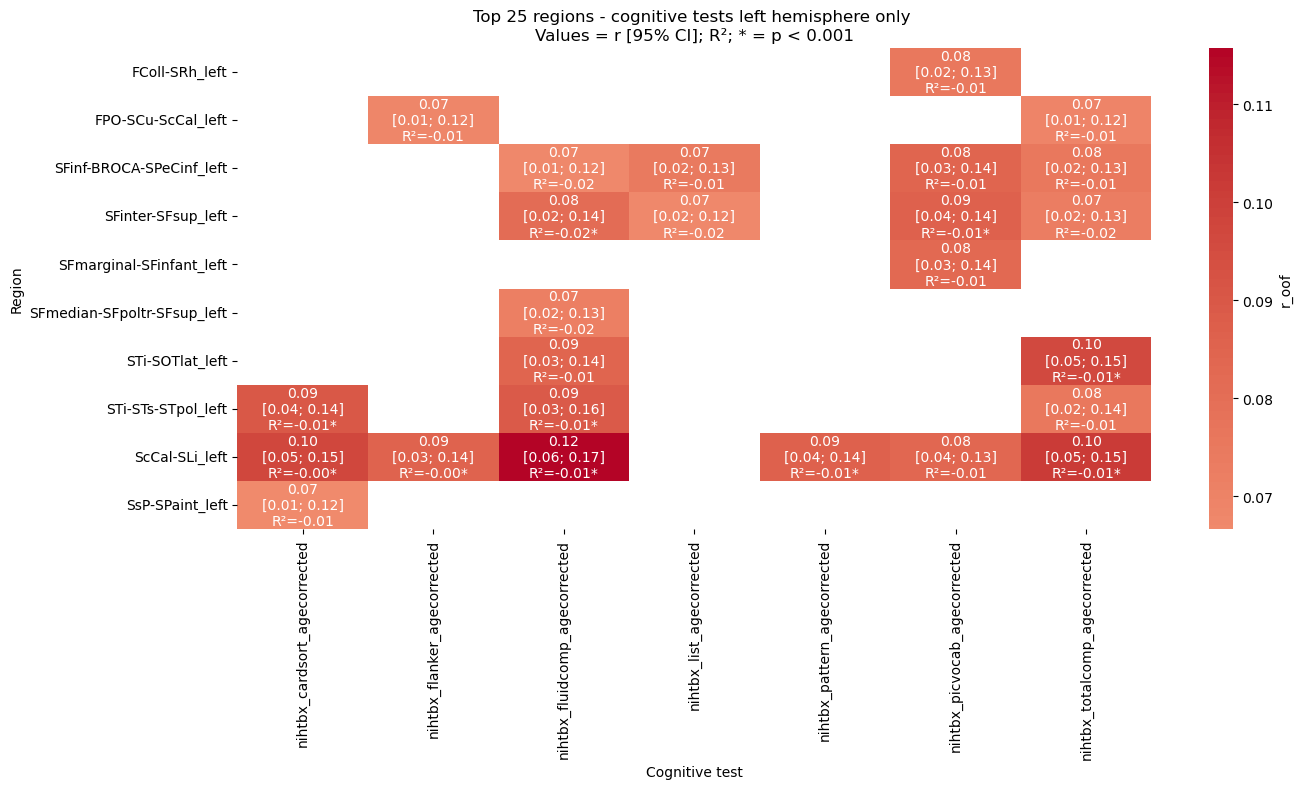

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load results ---
results_df = pd.read_csv(
    "/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/ABCD_cog_regression_all.csv"
)
print("results_df shape:", results_df.shape)

# --- 2. Filter to left hemisphere ---
results_df = results_df[results_df['region'].str.contains('_left')]

# --- 3. Select top 20 by r_oof ---
top20_df = results_df.sort_values(by='r_oof', ascending=False).head(25)
top20_df = top20_df[['region', 'score', 'r_oof', 'r_oof_ci95', 'p_pearson', 'r2_mean']]
print("Top 20 results by r_oof :")
print(top20_df)

# --- 4. Correction for multiple testing (Bonferroni) ---
n_tests = results_df.shape[0]
alpha_corr = 0.001

# --- 5. Build annotation matrix safely ---
def make_label(r, ci, r2, p):
    try:
        ci_low, ci_high = eval(ci) if isinstance(ci, str) else ci
    except Exception:
        ci_low, ci_high = (None, None)
    star = "*" if p < alpha_corr else ""
    if ci_low is not None:
        return f"{r:.2f}\n[{ci_low:.2f}; {ci_high:.2f}]\nR²={r2:.2f}{star}"
    else:
        return f"{r:.2f}\nR²={r2:.2f}{star}"

# pivot for values
heatmap_data = top20_df.pivot(index="region", columns="score", values="r_oof")

# initialize annotation matrix with empty strings
annot = heatmap_data.copy().astype(str)

# fill only for existing rows
for _, row in top20_df.iterrows():
    i, j = row["region"], row["score"]
    annot.loc[i, j] = make_label(row["r_oof"], row["r_oof_ci95"], row["r2_mean"], row["p_pearson"])

# --- 6. Heatmap ---
plt.figure(figsize=(14, 8))
ax = sns.heatmap(
    heatmap_data,
    annot=annot, fmt="", cmap="coolwarm", center=0,
    cbar_kws={"label": "r_oof"}
)
plt.title("Top 25 regions - cognitive tests left hemisphere only \nValues = r [95% CI]; R²; * = p < 0.001")
plt.ylabel("Region")
plt.xlabel("Cognitive test")
plt.tight_layout()
plt.show()


In [56]:
results_df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/final/prematurity/ABCD_prematurity_cog_regression.csv")

results_totalcomp = results_df[results_df['score'] == 'nihtbx_totalcomp_agecorrected']
results_picvocab = results_df[results_df['score'] == 'nihtbx_picvocab_agecorrected']

def adjust_r_oof(df):
    def adjust(row):
        ci95_fisher = ast.literal_eval(row['r_oof_ci95_fisher'])
        # critère 1: IC95 inclut 0
        ci_includes_zero = (ci95_fisher[0] <= 0 <= ci95_fisher[1])
        # critère 2: p-value >= 0.001
        p_too_high = row['p_pearson'] >= 0.001
        if ci_includes_zero or p_too_high:
            return 0.0
        return row['r_oof']
    df = df.copy()
    df['adjusted_r_oof'] = df.apply(adjust, axis=1)
    return df

# Appliquer
results_totalcomp = adjust_r_oof(results_totalcomp)
results_picvocab = adjust_r_oof(results_picvocab)

# Sélectionner colonnes utiles
results_totalcomp = results_totalcomp[['region','adjusted_r_oof','r_oof','r_oof_ci95_fisher','p_pearson']].sort_values(by='adjusted_r_oof', ascending=False)
results_picvocab = results_picvocab[['region','adjusted_r_oof','r_oof','r_oof_ci95_fisher','p_pearson']].sort_values(by='adjusted_r_oof', ascending=False)

# Sauvegarde
results_totalcomp.to_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/final/whole_brain_visu/ABCD_prematurity_totalcomp_results_adjusted_prema.csv", index=False)
results_picvocab.to_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/final/whole_brain_visu/ABCD_prematurity_picvocab_results_adjusted_prema.csv", index=False)

print("CSV sauvegardés")


CSV sauvegardés


In [ ]:
# Charger le fichier CSV d'origine
df = pd.read_csv('/neurospin/dico/rmenasria/Runs/03_main/Output/csv/ABCD_prematurity_results_0708.csv')

# Remplacer les AUC_mean non significatifs (p_value >= 0.05) par 0
df.loc[df['perm_pvalue'] >= 0.005, 'cv_auc_mean'] = 0.0

# Pivot pour avoir une colonne AUC par tranche
df_pivot = df.pivot(index='region', columns='threshold', values='cv_auc_mean')

# Renommer les colonnes
df_pivot = df_pivot.rename(columns={
    '28-32': 'AUC_28_32',
    '32-37': 'AUC_37'
}).reset_index()

# Exporter le résultat
output_csv = '/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/prematurity_AUC_by_region_ABCD_0708_thresholded.csv'
df_pivot.to_csv(output_csv, index=False)
print(f"Fichier généré : {output_csv}")